
# Introduction

##  Objective
The goal of this project is to implement and compare three popular deep learning architectures for image segmentation: UNet, FPN (Feature Pyramid Network), and DeepLabV3+. We aim to evaluate their performance on a human segmentation dataset in terms of segmentation accuracy, Dice coefficient, IoU, including total training time and resource usage.














# **Step 1: Install Required Libraries und DATA**

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 12.6 MB/s eta 0:00:00
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-adgo3f43
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-adgo3f43
  Resolved https://github.com/albumentations-team/albumentations to commit 66212d77a44927a29d6a0e81621d3c27afbd929c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.24
    Uninstalling albucore-0.0.24:
      Successfully uninstalled albucore-0.0.24
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires albucore==0.0.24, but you have albucore 0.0.28 which is incompatible

# Installation Dataset
---

* Dataset Name: Human Segmentation Dataset


* Content: RGB images + corresponding binary masks

* Mask Meaning:

  1 → human present

  0 → background / human absent

* Number of Samples: 290


In [2]:
 !git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 14.74 MiB/s, done.
Resolving deltas: 100% (3/3), done.


# **Step 2: Import Libraries**

In [3]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import albumentations as A

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [4]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive




# **Step 3: Data Preparation**


*  Loading the dataset (train / validation)



In [6]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE ='cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER ='timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [8]:
print(f"Total images: {len(df)}")

Total images: 290


In [9]:
train_df , valid_df = train_test_split(df, test_size = 0.2 , random_state = 42)



* Visualizing sample images and masks







In [10]:
def show_image_and_mask(image, mask,pred_image = None, title_image="Image", title_mask="Mask"):
  if pred_image == None:
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

    ax1.set_title(title_image)  # Titre du premier subplot
    ax1.imshow(image)       # Affiche l'image originale

    ax2.set_title(title_mask)  # Titre du deuxième subplot
    ax2.imshow(mask,cmap = 'gray')  # Affiche le masque en niveaux de gris

  elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')


In [11]:
# Select a specific row from the DataFrame (here the 33rd row as index starts at 0)
row = df.iloc[32]

# Get the image and mask paths
image_path = row.images
mask_path = row.masks
image = cv2.imread(image_path)
# Convert BGR → RGB because matplotlib and models use RGB.
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/ 255.0

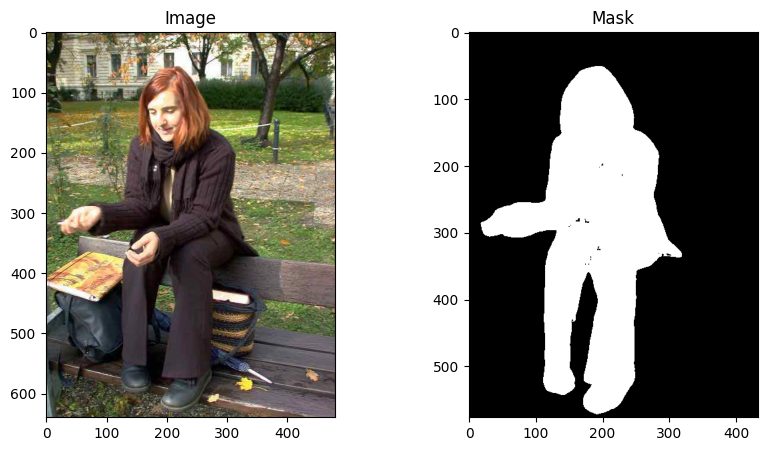

In [12]:
show_image_and_mask(image, mask)

* Explanation of the data format (RGB images + binary masks)




In [13]:
print("Image shape:", image.shape)
print("Mask shape:", mask.shape)
print("Mask unique values:", np.unique(mask))

Image shape: (640, 480, 3)
Mask shape: (577, 433)
Mask unique values: [0. 1.]




# **Step 4: Data Augmentation**

* We use the albumentations library to apply data augmentation to our training dataset. Augmentation helps improve the generalization of the model, especially when the dataset is small.




In [14]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
      ], is_check_shapes=False)
def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
      ], is_check_shapes=False)


* Example: Image before and after augmentation





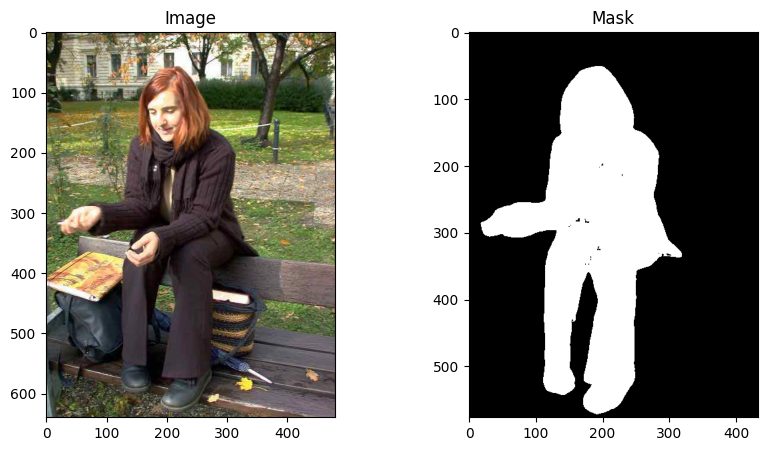

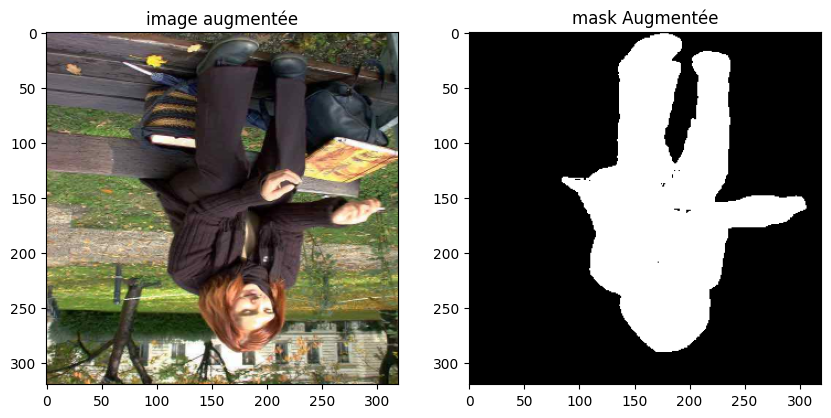

In [15]:
# Original image and mask
show_image_and_mask(image, mask)

# Apply augmentation
augs = get_train_augs()
augmented = augs(image=image, mask=mask)
image_aug = augmented['image']
mask_aug = augmented['mask']

# Display augmented image and mask
show_image_and_mask(image_aug, mask_aug,title_image="image augmentée",title_mask="mask Augmentée")


# **Step 5: Creating the Dataset and DataLoader**

* Definition of the custom SegmentationDataset class





In [16]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    # Lecture
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    mask = np.expand_dims(mask, axis = -1)


    # Augmentations
    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    # (h, w, c) -> (c, h, w)
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    # Conversion en Tensor
    image = torch.tensor(image) / 255.0

    mask = torch.tensor(mask)
    mask = torch.round(mask / 255.0)
    return image, mask

In [17]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [18]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58



* Loading the training and validation batches using the DataLoader



In [19]:
trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size= BATCH_SIZE)

In [20]:
print(f"total on , of batches in trainloadder ; {len(trainloader)}")
print(f"total on , of batches in validloadder ; {len(validloader)}")

total on , of batches in trainloadder ; 15
total on , of batches in validloadder ; 4


* Checking that the data pipeline works correctly


In [21]:
for images, masks in trainloader:
    break

print(f"One batch image shape : {images.shape}")
print(f"One batch mask shape : {masks.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# **Step 6: Building the Segmentation Model**

* Implementation of the SegmentationModel class

*  Model Architecture Selection (U-Net, FPN, DeepLabV3+)

*  Loss Function Definition (Dice Loss + Binary Cross-Entropy)


In [22]:
class SegmentationModel(nn.Module):
    def __init__(self, arch='unet'):  # arch ici contrôle l’architecture
        super(SegmentationModel, self).__init__()

        self.arc = None

        if arch == 'unet':
            self.arc = smp.Unet(
                encoder_name=ENCODER,
                encoder_weights=WEIGHTS,
                in_channels=3,
                classes=1,
                activation=None
            )
        elif arch == 'fpn':
            self.arc = smp.FPN(
                encoder_name=ENCODER,
                encoder_weights=WEIGHTS,
                in_channels=3,
                classes=1,
                activation=None
            )
        elif arch == 'deeplabv3+':
            self.arc = smp.DeepLabV3Plus(
                encoder_name=ENCODER,
                encoder_weights=WEIGHTS,
                in_channels=3,
                classes=1,
                activation=None
            )
        else:
            raise ValueError(f"Architecture {arch} not supported")

    def forward(self, images, masks=None):
        logits = self.arc(images)
        if masks is not None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2
        return logits


In [23]:
model_unet = SegmentationModel(arch='unet')
model_unet.to(DEVICE);


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [24]:
model_fpn = SegmentationModel(arch='fpn').to(DEVICE)


In [25]:
model_deeplab = SegmentationModel(arch='deeplabv3+').to(DEVICE)

# **Step 7: Model Training**

* Training and validation loops



In [26]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images , masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [27]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images , masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)


      logits, loss = model(images, masks)


      total_loss += loss.item()

  return total_loss / len(data_loader)

* Computation of losses and metrics (IoU, Dice score)

* Saving the best-performing model based on validation loss



###   **model_unet**




In [28]:
import time
optimizer_unet  = torch.optim.Adam(model_unet.parameters(),lr = LR)

In [29]:
best_valid_loss_unet = np.inf

start_time = time.time()
for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model_unet, optimizer_unet)
  valid_loss = eval_fn(validloader, model_unet)


  if valid_loss < best_valid_loss_unet:
    torch.save(model_unet.state_dict(),'best_model_unet.pt')
    print("SAVED-MODEL")
    best_valid_loss_unet = valid_loss

  print(f"Epoch : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")

end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds")


100%|██████████| 4/4 [00:00<00:00,  6.00it/s]


SAVED-MODEL
Epoch : 1 train_loss : 0.7111873010794322 valid_loss : 0.7505156844854355


100%|██████████| 4/4 [00:00<00:00,  6.29it/s]


SAVED-MODEL
Epoch : 2 train_loss : 0.3873261253039042 valid_loss : 0.6811596602201462


100%|██████████| 4/4 [00:00<00:00,  6.23it/s]


SAVED-MODEL
Epoch : 3 train_loss : 0.2960139284531275 valid_loss : 0.25978652387857437


100%|██████████| 4/4 [00:00<00:00,  6.31it/s]


Epoch : 4 train_loss : 0.241389666001002 valid_loss : 0.28546011820435524


100%|██████████| 4/4 [00:00<00:00,  6.27it/s]


Epoch : 5 train_loss : 0.27398342788219454 valid_loss : 0.36862677335739136


100%|██████████| 4/4 [00:00<00:00,  4.43it/s]


SAVED-MODEL
Epoch : 6 train_loss : 0.23800705472628275 valid_loss : 0.20968234911561012


100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


Epoch : 7 train_loss : 0.18393063644568125 valid_loss : 0.21089110895991325


100%|██████████| 4/4 [00:00<00:00,  6.34it/s]


Epoch : 8 train_loss : 0.16564937631289164 valid_loss : 0.27965111285448074


100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


Epoch : 9 train_loss : 0.19724110265572867 valid_loss : 0.22830364853143692


100%|██████████| 4/4 [00:00<00:00,  5.25it/s]


Epoch : 10 train_loss : 0.17265030443668367 valid_loss : 0.2424544133245945


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Epoch : 11 train_loss : 0.21664112359285354 valid_loss : 0.25452636182308197


100%|██████████| 4/4 [00:00<00:00,  6.32it/s]


Epoch : 12 train_loss : 0.2234162320693334 valid_loss : 0.22807293012738228


100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


Epoch : 13 train_loss : 0.18609555910031 valid_loss : 0.21806323528289795


100%|██████████| 4/4 [00:00<00:00,  6.25it/s]


SAVED-MODEL
Epoch : 14 train_loss : 0.14699929455916086 valid_loss : 0.20256761461496353


100%|██████████| 4/4 [00:00<00:00,  6.35it/s]


Epoch : 15 train_loss : 0.13513243893782298 valid_loss : 0.23280822858214378


100%|██████████| 4/4 [00:00<00:00,  6.28it/s]


Epoch : 16 train_loss : 0.1553691655397415 valid_loss : 0.2303486168384552


100%|██████████| 4/4 [00:00<00:00,  6.30it/s]


SAVED-MODEL
Epoch : 17 train_loss : 0.12028629680474599 valid_loss : 0.19391778483986855


100%|██████████| 4/4 [00:00<00:00,  6.29it/s]


SAVED-MODEL
Epoch : 18 train_loss : 0.11369546254475911 valid_loss : 0.18484701961278915


100%|██████████| 4/4 [00:00<00:00,  6.33it/s]


SAVED-MODEL
Epoch : 19 train_loss : 0.12992145866155624 valid_loss : 0.14571250975131989


100%|██████████| 4/4 [00:00<00:00,  6.19it/s]


Epoch : 20 train_loss : 0.1156998927394549 valid_loss : 0.2178605981171131


100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


Epoch : 21 train_loss : 0.12124807337919871 valid_loss : 0.2094089835882187


100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Epoch : 22 train_loss : 0.15242410351832708 valid_loss : 0.2946729101240635


100%|██████████| 4/4 [00:00<00:00,  6.28it/s]


Epoch : 23 train_loss : 0.2131620446840922 valid_loss : 0.42801031470298767


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


Epoch : 24 train_loss : 0.1567600429058075 valid_loss : 0.30396342277526855


100%|██████████| 4/4 [00:00<00:00,  6.28it/s]

Epoch : 25 train_loss : 0.1566290184855461 valid_loss : 0.2117381952702999
Time taken: 175.04 seconds


### **model_fpn**

In [30]:
optimizer_fpn = torch.optim.Adam(model_fpn.parameters(),lr = LR)

In [31]:
best_valid_loss_fpn = np.inf

start_time = time.time()
for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model_fpn, optimizer_fpn)
  valid_loss = eval_fn(validloader, model_fpn)

  if valid_loss < best_valid_loss_fpn:
    torch.save(model_fpn.state_dict(),'best_model_fpn.pt')
    print("SAVED-MODEL")
    best_valid_loss_fpn = valid_loss

  print(f"Epoch : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")

end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds")

100%|██████████| 4/4 [00:00<00:00,  5.80it/s]


SAVED-MODEL
Epoch : 1 train_loss : 1.3768245259920755 valid_loss : 1.451030284166336


100%|██████████| 4/4 [00:00<00:00,  6.57it/s]


SAVED-MODEL
Epoch : 2 train_loss : 0.4025189061959585 valid_loss : 0.3327970430254936


100%|██████████| 4/4 [00:00<00:00,  6.70it/s]


SAVED-MODEL
Epoch : 3 train_loss : 0.2869778056939443 valid_loss : 0.2835814878344536


100%|██████████| 4/4 [00:00<00:00,  6.73it/s]


SAVED-MODEL
Epoch : 4 train_loss : 0.2546191116174062 valid_loss : 0.22245484963059425


100%|██████████| 4/4 [00:00<00:00,  6.74it/s]


SAVED-MODEL
Epoch : 5 train_loss : 0.18988219499588013 valid_loss : 0.20069998130202293


100%|██████████| 4/4 [00:00<00:00,  6.73it/s]


Epoch : 6 train_loss : 0.17052758038043975 valid_loss : 0.20956970751285553


100%|██████████| 4/4 [00:00<00:00,  6.60it/s]


Epoch : 7 train_loss : 0.20973206808169684 valid_loss : 0.2019914574921131


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


Epoch : 8 train_loss : 0.17609785099824268 valid_loss : 0.22043302655220032


100%|██████████| 4/4 [00:00<00:00,  6.73it/s]


SAVED-MODEL
Epoch : 9 train_loss : 0.14761743446191153 valid_loss : 0.19274097681045532


100%|██████████| 4/4 [00:00<00:00,  6.56it/s]


Epoch : 10 train_loss : 0.139622067908446 valid_loss : 0.21345868706703186


100%|██████████| 4/4 [00:00<00:00,  6.66it/s]


Epoch : 11 train_loss : 0.13870105097691218 valid_loss : 0.24423370510339737


100%|██████████| 4/4 [00:00<00:00,  6.74it/s]


SAVED-MODEL
Epoch : 12 train_loss : 0.12925344109535217 valid_loss : 0.17857721261680126


100%|██████████| 4/4 [00:00<00:00,  6.60it/s]


Epoch : 13 train_loss : 0.12732457568248112 valid_loss : 0.18532999232411385


100%|██████████| 4/4 [00:00<00:00,  6.72it/s]


SAVED-MODEL
Epoch : 14 train_loss : 0.11760147958993912 valid_loss : 0.16846362501382828


100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Epoch : 15 train_loss : 0.10845293452342351 valid_loss : 0.17245350778102875


100%|██████████| 4/4 [00:00<00:00,  6.68it/s]


Epoch : 16 train_loss : 0.10300250301758448 valid_loss : 0.17401495948433876


100%|██████████| 4/4 [00:00<00:00,  6.28it/s]


Epoch : 17 train_loss : 0.11385176926851273 valid_loss : 0.17264335602521896


100%|██████████| 4/4 [00:00<00:00,  6.77it/s]


SAVED-MODEL
Epoch : 18 train_loss : 0.10566327671209971 valid_loss : 0.15040498971939087


100%|██████████| 4/4 [00:00<00:00,  6.70it/s]


Epoch : 19 train_loss : 0.10482495178778967 valid_loss : 0.16610346175730228


100%|██████████| 4/4 [00:00<00:00,  6.62it/s]


Epoch : 20 train_loss : 0.10396652817726135 valid_loss : 0.17221511900424957


100%|██████████| 4/4 [00:00<00:00,  6.74it/s]


Epoch : 21 train_loss : 0.09238648215929667 valid_loss : 0.19233113899827003


100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


Epoch : 22 train_loss : 0.0933512086669604 valid_loss : 0.17792201600968838


100%|██████████| 4/4 [00:00<00:00,  6.75it/s]


Epoch : 23 train_loss : 0.0952070896824201 valid_loss : 0.18373868614435196


100%|██████████| 4/4 [00:00<00:00,  6.17it/s]


Epoch : 24 train_loss : 0.10742541601260504 valid_loss : 0.20370091311633587


100%|██████████| 4/4 [00:00<00:00,  6.56it/s]

Epoch : 25 train_loss : 0.09525850464900334 valid_loss : 0.19732140935957432
Time taken: 138.65 seconds


### **model_deeplab**

In [32]:
optimizer_deeplab = torch.optim.Adam(model_fpn.parameters(),lr = LR)

In [ ]:
best_valid_loss_deeplab = np.inf

start_time = time.time()
for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model_deeplab, optimizer_deeplab)
  valid_loss = eval_fn(validloader, model_deeplab)

  if valid_loss < best_valid_loss_deeplab:
    torch.save(model_deeplab.state_dict(),'best_model_deeplab.pt')
    print("SAVED-MODEL")
    best_valid_loss_deeplab = valid_loss

  print(f"Epoch : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")

end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds")

100%|██████████| 4/4 [00:00<00:00,  6.32it/s]


SAVED-MODEL
Epoch : 1 train_loss : 1.3317657550175985 valid_loss : 1.3363207876682281


100%|██████████| 4/4 [00:00<00:00,  6.43it/s]


SAVED-MODEL
Epoch : 2 train_loss : 1.3325833876927693 valid_loss : 1.3352900743484497


100%|██████████| 4/4 [00:00<00:00,  6.44it/s]


Epoch : 3 train_loss : 1.3312769095102945 valid_loss : 1.3356514275074005


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Epoch : 4 train_loss : 1.3329370975494386 valid_loss : 1.3364217281341553


100%|██████████| 4/4 [00:00<00:00,  6.50it/s]


Epoch : 5 train_loss : 1.3320735216140747 valid_loss : 1.335348755121231


100%|██████████| 4/4 [00:00<00:00,  6.41it/s]


Epoch : 6 train_loss : 1.3282543182373048 valid_loss : 1.3371209800243378


100%|██████████| 4/4 [00:00<00:00,  6.46it/s]


SAVED-MODEL
Epoch : 7 train_loss : 1.3295372327168782 valid_loss : 1.3348677158355713


100%|██████████| 4/4 [00:00<00:00,  6.48it/s]


Epoch : 8 train_loss : 1.3333795309066772 valid_loss : 1.3349167704582214


100%|██████████| 4/4 [00:00<00:00,  6.35it/s]


Epoch : 9 train_loss : 1.333001152674357 valid_loss : 1.336877703666687


100%|██████████| 4/4 [00:00<00:00,  6.46it/s]


Epoch : 10 train_loss : 1.3305116891860962 valid_loss : 1.3351119458675385


100%|██████████| 4/4 [00:00<00:00,  6.30it/s]


Epoch : 11 train_loss : 1.331148346265157 valid_loss : 1.3351585268974304


100%|██████████| 4/4 [00:00<00:00,  6.49it/s]


SAVED-MODEL
Epoch : 12 train_loss : 1.3294382174809773 valid_loss : 1.3340908586978912


100%|██████████| 4/4 [00:00<00:00,  6.37it/s]


Epoch : 13 train_loss : 1.3314685106277466 valid_loss : 1.3362524807453156


100%|██████████| 4/4 [00:00<00:00,  6.41it/s]


Epoch : 14 train_loss : 1.3316399176915488 valid_loss : 1.3357727229595184


100%|██████████| 4/4 [00:00<00:00,  6.36it/s]


SAVED-MODEL
Epoch : 15 train_loss : 1.3307784795761108 valid_loss : 1.333404779434204


100%|██████████| 4/4 [00:00<00:00,  6.44it/s]


Epoch : 16 train_loss : 1.3318683783213296 valid_loss : 1.335148274898529


100%|██████████| 4/4 [00:00<00:00,  6.47it/s]


Epoch : 17 train_loss : 1.326923624674479 valid_loss : 1.3345986306667328


100%|██████████| 4/4 [00:00<00:00,  6.47it/s]


Epoch : 18 train_loss : 1.3325657606124879 valid_loss : 1.3358262181282043


100%|██████████| 4/4 [00:00<00:00,  6.46it/s]


Epoch : 19 train_loss : 1.3335876305898031 valid_loss : 1.3353695273399353


 27%|██▋       | 4/15 [00:01<00:04,  2.63it/s]

# **Step 8: Evaluation and Results**
* Visualizationof predictions on validation images
* Comparison of performance between the architectures
*  Discussion of the results

In [ ]:
import torch

def compute_metrics(pred_mask, true_mask, threshold=0.5):
    """
    pred_mask : torch.Tensor (B, 1, H, W), logits ou probabilities
    true_mask : torch.Tensor (B, 1, H, W), valeurs 0 ou 1
    """
    pred_mask = (torch.sigmoid(pred_mask) > threshold).float()
    true_mask = true_mask.float()

    # Flatten
    pred_flat = pred_mask.view(-1)
    true_flat = true_mask.view(-1)

    # True Positives, False Positives, False Negatives
    TP = (pred_flat * true_flat).sum()
    FP = (pred_flat * (1 - true_flat)).sum()
    FN = ((1 - pred_flat) * true_flat).sum()

    # Dice
    dice = (2 * TP) / (2 * TP + FP + FN + 1e-8)

    # IoU
    iou = TP / (TP + FP + FN + 1e-8)

    return dice.item(), iou.item()


In [ ]:
def eval_metrics(data_loader, model):
    model.eval()
    total_dice = 0
    total_iou = 0
    total_acc = 0
    total_pixels = 0

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits = model(images)

            dice, iou = compute_metrics(logits, masks)
            total_dice += dice
            total_iou += iou

            # Accuracy
            pred_mask = (torch.sigmoid(logits) > 0.5).float()
            correct = (pred_mask == masks).sum().item()
            total_acc += correct
            total_pixels += masks.numel()

    n_batches = len(data_loader)
    avg_dice = total_dice / n_batches
    avg_iou = total_iou / n_batches
    avg_acc = total_acc / total_pixels

    return avg_dice, avg_iou, avg_acc


In [43]:
#Load the best UNet model
model_unet.load_state_dict(torch.load('best_model_unet.pt'))
model_unet.to(DEVICE)


#Load the best Fpn model
model_fpn.load_state_dict(torch.load('best_model_fpn.pt'))
model_fpn.to(DEVICE)

#Load the best deeplab model
model_deeplab.load_state_dict(torch.load('best_model_deeplab.pt'))
model_deeplab.to(DEVICE);

In [44]:
# UNet
dice_unet, iou_unet, acc_unet = eval_metrics(validloader, model_unet)

# FPN
dice_fpn, iou_fpn, acc_fpn = eval_metrics(validloader, model_fpn)

# DeepLabV3+
dice_dl, iou_dl, acc_dl = eval_metrics(validloader, model_deeplab)

print("UNet     -> Dice: {:.4f}, IoU: {:.4f}, Acc: {:.4f}".format(dice_unet, iou_unet, acc_unet))
print("FPN      -> Dice: {:.4f}, IoU: {:.4f}, Acc: {:.4f}".format(dice_fpn, iou_fpn, acc_fpn))
print("DeepLabV3+ -> Dice: {:.4f}, IoU: {:.4f}, Acc: {:.4f}".format(dice_dl, iou_dl, acc_dl))


100%|██████████| 4/4 [00:00<00:00,  6.11it/s]

UNet     -> Dice: 0.9505, IoU: 0.9059, Acc: 0.9737
FPN      -> Dice: 0.9485, IoU: 0.9021, Acc: 0.9722
DeepLabV3+ -> Dice: 0.2505, IoU: 0.1452, Acc: 0.6050


In [ ]:
idx = 20

image, mask = validset[idx]

logits_mask_unet = model_unet(image.to(DEVICE).unsqueeze(0)) #(c,H,W) -> (1, C, H, W )

logits_mask_fpn = model_fpn(image.to(DEVICE).unsqueeze(0)) #(c,H,W) -> (1, C, H, W )

logits_mask_deeplab = model_deeplab(image.to(DEVICE).unsqueeze(0)) #(c,H,W) -> (1, C, H, W )

perd_mask_unet = torch.sigmoid(logits_mask_unet)
perd_mask_unet = (perd_mask_unet > 0.5)* 1.0

perd_mask_fpn = torch.sigmoid(logits_mask_fpn)
perd_mask_fpn = (perd_mask_fpn > 0.5)* 1.0

perd_mask_deeplab = torch.sigmoid(logits_mask_deeplab)
perd_mask_deeplab = (perd_mask_deeplab > 0.5)* 1.0

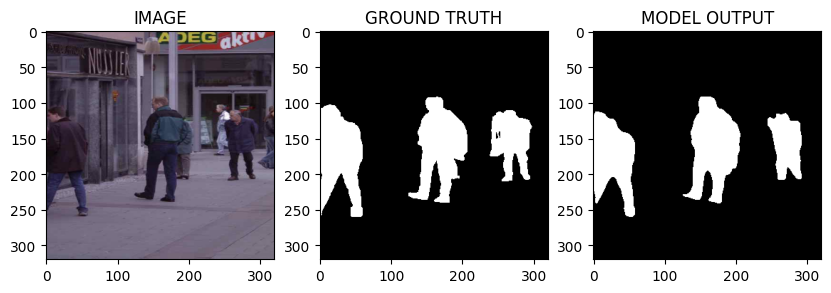

In [45]:
#Predicted mask by Unet
show_image_and_mask(image, mask,  perd_mask_unet.detach().cpu().squeeze(0),
                    title_image="Original Image", title_mask="Ground Truth")




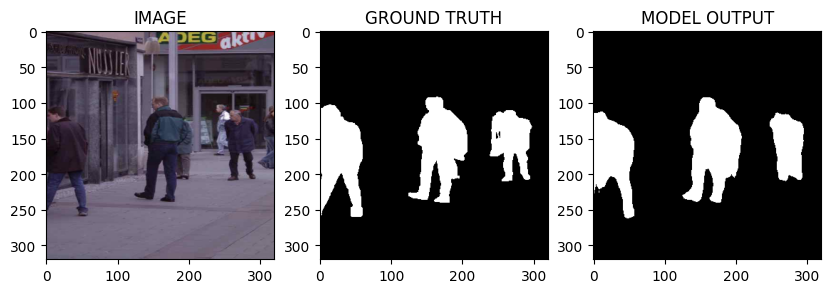

In [40]:
#Predicted mask by FPN
show_image_and_mask(image, mask,  perd_mask_fpn.detach().cpu().squeeze(0),
                    title_image="FPN Prediction", title_mask="FPN Mask")


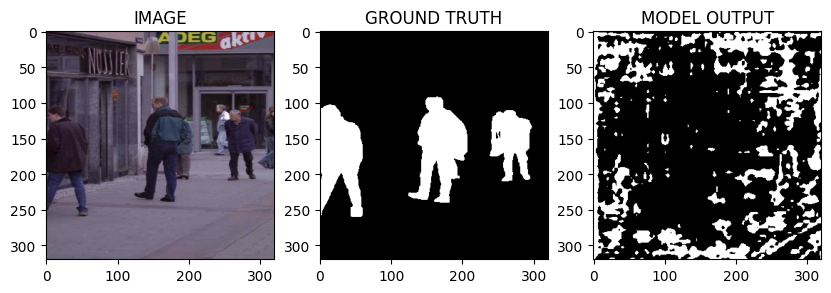

In [41]:

#Predicted mask by DeepLabV3+
show_image_and_mask(image, mask,  perd_mask_deeplab.detach().cpu().squeeze(0),
                    title_image="DeepLabV3+ Prediction", title_mask="DeepLab Mask")